In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df = pd.read_csv('assists-data-05.csv')

print(df.shape)
df.head()

(18329, 104)


,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
0,A.C. Green,1986.0,NBA,4.0,22.0,LAL,82.0,1.0,18.8,2.5,...,82.293333,113.353333,20.257500,13.859167,47.038333,52.697500,291.443333,84.985833,75.868561,0.0
1,A.C. Green,1987.0,NBA,4.0,23.0,LAL,79.0,72.0,28.4,4.0,...,83.363636,117.330000,24.980000,14.811818,53.943636,64.157273,346.999091,103.644545,93.370094,0.0
2,A.C. Green,1988.0,NBA,4.0,24.0,LAL,82.0,64.0,32.1,3.9,...,78.923333,112.674167,22.459167,14.959167,42.338333,52.324167,314.798333,81.284167,81.034171,0.0
3,A.C. Green,1989.0,NBA,4.0,25.0,LAL,82.0,82.0,30.6,4.9,...,97.425455,138.156364,27.462727,15.890909,54.841818,68.721818,396.150000,101.753636,93.719806,0.0
4,A.C. Green,1990.0,NBA,4.0,26.0,LAL,82.0,82.0,33.0,4.7,...,104.722222,146.236667,28.225556,13.398889,53.021111,59.227778,389.544444,100.957778,101.027904,1.0


In [14]:
df['Year'].describe()

count    18329.000000
mean      1991.977686
std         17.942735
min       1947.000000
25%       1979.000000
50%       1995.000000
75%       2007.000000
max       2018.000000
Name: Year, dtype: float64

In [15]:
df.describe(exclude=np.number)

,Player,Lge,Tm
count,18329,18329,18329
unique,3308,3,103
top,Eddie Johnson,NBA,NYK
freq,25,17321,826


In [16]:
test = df[df['Year'] == 2018]
temp = df[df['Year'] < 2018]
train = temp[temp['Year'] < 2014]
val = temp[temp['Year'] >= 2014]

In [17]:
from sklearn.metrics import mean_squared_error

baseline = val['AST']

baseline_mse = mean_squared_error(baseline, val['Target'])

baseline_mse

0.8528051787916153

In [18]:
non_features = ['Player', 'Tm', 'Target']
X_train = train.drop(non_features, axis=1)
y_train = train['Target']
X_val = val.drop(non_features, axis=1)
y_val = val['Target']

X_train_full = temp.drop(non_features, axis=1)
y_train_full = temp['Target']
X_test = test.drop(non_features, axis=1)
y_test = test['Target']

In [19]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train_full_encoded = encoder.fit_transform(X_train_full)
X_test_encoded = encoder.transform(X_test)

In [20]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression

lowest = [0.9, 1]
for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_encoded, y_train)
    X_val_selected = selector.transform(X_val_encoded)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)
    
    mse = mean_squared_error(y_val, y_pred)
    
    if mse < lowest[0]:
        lowest[0] = mse
        lowest[1] = k
    
    print(f'Val MSE: {mse} \n')
    print(f'Lowest so far: k = {lowest[1]} with mse = {lowest[0]}' )

1 features
Val MSE: 0.7850088456329357 

Lowest so far: k = 1 with mse = 0.7850088456329357
2 features
Val MSE: 0.7860203694108553 

Lowest so far: k = 1 with mse = 0.7850088456329357
3 features
Val MSE: 0.7772156591255995 

Lowest so far: k = 3 with mse = 0.7772156591255995
4 features
Val MSE: 0.7744580256864821 

Lowest so far: k = 4 with mse = 0.7744580256864821
5 features
Val MSE: 0.7709289074800788 

Lowest so far: k = 5 with mse = 0.7709289074800788
6 features
Val MSE: 0.7681483142759943 

Lowest so far: k = 6 with mse = 0.7681483142759943
7 features
Val MSE: 0.7649133087487267 

Lowest so far: k = 7 with mse = 0.7649133087487267
8 features
Val MSE: 0.7653029241452155 

Lowest so far: k = 7 with mse = 0.7649133087487267
9 features
Val MSE: 0.7605063113299796 

Lowest so far: k = 9 with mse = 0.7605063113299796
10 features
Val MSE: 0.7530997783465972 

Lowest so far: k = 10 with mse = 0.7530997783465972
11 features
Val MSE: 0.7454434479178579 

Lowest so far: k = 11 with mse = 0.7

In [21]:
selector = SelectKBest(score_func=f_regression, k=101)

X_train_full_selected = selector.fit_transform(X_train_full_encoded, y_train_full)
X_test_selected = selector.transform(X_test_encoded)

model = LinearRegression()

model.fit(X_train_full_selected, y_train_full)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
def determine_error(test, model):

    y_pred = model.predict(test)

    model_mse = mean_squared_error(y_test, y_pred)

    improvement = baseline_mse - model_mse

    percent_improve = (improvement / baseline_mse) * 100

    print('Model mean squared error:', model_mse)
    print('Baseline mean squared error:', baseline_mse)
    print('Improvement over baseline:', improvement)
    print(f'Percent improvement: {percent_improve}%')
    
determine_error(test=X_test_selected, model=model)

Model mean squared error: 0.7772527319188982
Baseline mean squared error: 0.8528051787916153
Improvement over baseline: 0.07555244687271712
Percent improvement: 8.859285655344094%


In [23]:
from sklearn.linear_model import Ridge

lowest = [1, 0]
for alpha in range(0, 1000, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train_encoded, y_train)
    mse = mean_squared_error(y_val, ridge_reg_split.predict(X_val_encoded))
    if mse < lowest[0]:
        lowest[0] = mse
        lowest[1] = alpha
    print(f'For alpha = {alpha}, mse = {mse}')
    print(f'Lowest so far: alpha = {lowest[1]}, mse = {lowest[0]}')

For alpha = 0, mse = 0.7096389184845574
Lowest so far: alpha = 0, mse = 0.7096389184845574
For alpha = 1, mse = 0.7070470468988852
Lowest so far: alpha = 1, mse = 0.7070470468988852
For alpha = 2, mse = 0.7068518536511176
Lowest so far: alpha = 2, mse = 0.7068518536511176
For alpha = 3, mse = 0.7067299906042649
Lowest so far: alpha = 3, mse = 0.7067299906042649


C:\Anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.42973e-22): result may not be accurate.
  overwrite_a=True).T


For alpha = 4, mse = 0.7066366348151458
Lowest so far: alpha = 4, mse = 0.7066366348151458
For alpha = 5, mse = 0.7065594300686969
Lowest so far: alpha = 5, mse = 0.7065594300686969
For alpha = 6, mse = 0.7064930058131178
Lowest so far: alpha = 6, mse = 0.7064930058131178
For alpha = 7, mse = 0.7064344419997615
Lowest so far: alpha = 7, mse = 0.7064344419997615
For alpha = 8, mse = 0.7063819272440459
Lowest so far: alpha = 8, mse = 0.7063819272440459
For alpha = 9, mse = 0.7063342388597463
Lowest so far: alpha = 9, mse = 0.7063342388597463
For alpha = 10, mse = 0.7062905026897799
Lowest so far: alpha = 10, mse = 0.7062905026897799
For alpha = 11, mse = 0.7062500674820196
Lowest so far: alpha = 11, mse = 0.7062500674820196
For alpha = 12, mse = 0.7062124328544686
Lowest so far: alpha = 12, mse = 0.7062124328544686
For alpha = 13, mse = 0.7061772050076288
Lowest so far: alpha = 13, mse = 0.7061772050076288
For alpha = 14, mse = 0.7061440679863493
Lowest so far: alpha = 14, mse = 0.706144

In [13]:
model = Ridge(alpha=431)

model.fit(X_train_full_encoded, y_train_full)

determine_error(test=X_test_encoded, model=model)

Model mean squared error: 0.7735357913149213
Baseline mean squared error: 0.8528051787916153
Improvement over baseline: 0.07926938747669399
Percent improvement: 9.295134392712644%


In [14]:
non_features = ['Player', 'Target']
X_train = train.drop(non_features, axis=1)
y_train = train['Target']
X_val = val.drop(non_features, axis=1)
y_val = val['Target']

X_train_full = temp.drop(non_features, axis=1)
y_train_full = temp['Target']
X_test = test.drop(non_features, axis=1)
y_test = test['Target']

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=100)
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0,1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 36.8min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 43.2min finished


In [16]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation mse', -search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.37423389453362177, 'randomforestregressor__n_estimators': 366}
Cross-validation mse 0.8113559965681203


In [20]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(max_depth=15, max_features=0.37, n_estimators=366, random_state=100)
)

pipeline.fit(X_train_full, y_train_full)

determine_error(test=X_test, model=pipeline)

Model mean squared error: 0.781380863074051
Baseline mean squared error: 0.8528051787916153
Improvement over baseline: 0.07142431571756436
Percent improvement: 8.375220682731928%


In [22]:
encoder2 = ce.OrdinalEncoder()
X_train_encoded2 = encoder2.fit_transform(X_train)
X_val_encoded2 = encoder2.transform(X_val)

from xgboost import XGBRegressor

eval_set = [(X_train_encoded2, y_train),
            (X_val_encoded2, y_val)]

model = XGBRegressor(
    n_estimators=1000,
    max_depth=2,
    learning_rate=0.1,
    n_jobs=-1
)

model.fit(X_train_encoded2, y_train, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[11:18:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.31344	validation_1-rmse:2.15422
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.13287	validation_1-rmse:1.98209
[2]	validation_0-rmse:1.97257	validation_1-rmse:1.8358
[3]	validation_0-rmse:1.83146	validation_1-rmse:1.70136
[4]	validation_0-rmse:1.7062	validation_1-rmse:1.58512
[5]	validation_0-rmse:1.59785	validation_1-rmse:1.48628
[6]	validation_0-rmse:1.5025	validation_1-rmse:1.39819
[7]	validation_0-rmse:1.41921	validation_1-rmse:1.31931
[8]	validation_0-rmse:1.34734	validation_1-rmse:1.25054
[9]	validation_0-rmse:1.28432	validation_1-rmse:1.19129
[10]	validation_0-rmse:1.23054	validation_1-rmse:1.14174
[11]	validation_0-rmse:1.18451	validation_1-rmse:1.0997
[12]	validation_0-rmse:1.14499	validation_1-rmse:1.0642

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
X_train_full_encoded2 = encoder2.fit_transform(X_train_full)
X_test_encoded2 = encoder2.transform(X_test)

eval_set = [(X_train_full_encoded2, y_train_full),
            (X_test_encoded2, y_test)]

model = XGBRegressor(
    n_estimators=1000,
    max_depth=2,
    learning_rate=0.1,
    n_jobs=-1
)

model.fit(X_train_encoded2, y_train, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[11:19:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.29948	validation_1-rmse:2.29909
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.11967	validation_1-rmse:2.12608
[2]	validation_0-rmse:1.96058	validation_1-rmse:1.97259
[3]	validation_0-rmse:1.82006	validation_1-rmse:1.83751
[4]	validation_0-rmse:1.6956	validation_1-rmse:1.71665
[5]	validation_0-rmse:1.58807	validation_1-rmse:1.61353
[6]	validation_0-rmse:1.49335	validation_1-rmse:1.52549
[7]	validation_0-rmse:1.41046	validation_1-rmse:1.44408
[8]	validation_0-rmse:1.33886	validation_1-rmse:1.37517
[9]	validation_0-rmse:1.27618	validation_1-rmse:1.31294
[10]	validation_0-rmse:1.22277	validation_1-rmse:1.2584
[11]	validation_0-rmse:1.17709	validation_1-rmse:1.21187
[12]	validation_0-rmse:1.13792	validation_1-rmse:1.17

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [24]:
determine_error(test=X_test_encoded2, model=model)

Model mean squared error: 0.7820473702926999
Baseline mean squared error: 0.8528051787916153
Improvement over baseline: 0.07075780849891544
Percent improvement: 8.2970659956798%


In [25]:
model = Ridge(alpha=431)

model.fit(X_train_full_encoded, y_train_full)

Ridge(alpha=431, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [1]:
import sklearn.metrics

sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_squared_error',
    n_iter=5,
    random_state=30
)

permuter.fit(X_test_encoded, y_test)

PermutationImportance(cv='prefit',
                      estimator=Ridge(alpha=431, copy_X=True,
                                      fit_intercept=True, max_iter=None,
                                      normalize=False, random_state=None,
                                      solver='auto', tol=0.001),
                      n_iter=5, random_state=30, refit=True,
                      scoring='neg_mean_squared_error')

In [27]:
feature_names = X_test_encoded.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.8561 ± 0.1565,PTS_adj
0.8032 ± 0.1119,AST_adj
0.7863 ± 0.1814,CAS
0.7805 ± 0.1211,AST
0.5494 ± 0.0522,TM_FG_adj
0.3168 ± 0.0909,3P_adj
0.2637 ± 0.0382,MP
0.1798 ± 0.0415,TM_2P_adj
0.1551 ± 0.0231,2P_adj
0.1545 ± 0.0452,2P%_adj


In [28]:
test2 = test.copy()
y_pred = model.predict(X_test_encoded)
test2['pred'] = y_pred
test2['mse'] = (test2['Target'] - test2['pred'])**2
test2['diff'] = abs(test2['AST'] - test2['pred'])
test3 = test2.sort_values(by='diff', ascending=False)

columns = test3.columns
move = ['Player', 'Year', 'Tm', 'AST', 'Target', 'pred', 'diff', 'mse']
test3 = test3[move + [c for c in columns if c not in move]]
test3.head()

,Player,Year,Tm,AST,Target,pred,diff,mse,Lge,Pos,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
7597,J.J. Barea,2018.0,DAL,6.3,5.6,4.666954,1.633046,0.870575,NBA,1.0,...,60.892143,75.372143,14.224286,6.806429,20.767857,34.737143,204.477143,39.792857,38.780504,0.0
6919,Gordon Hayward,2018.0,BOS,0.0,3.4,1.293983,1.293983,4.435309,NBA,3.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,0.0
207,Al Horford,2018.0,BOS,4.7,4.2,3.473068,1.226932,0.528431,NBA,5.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,2.0
4803,Derrick Rose,2018.0,CLE,1.5,4.3,2.681525,1.181525,2.619460,NBA,1.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
5366,Draymond Green,2018.0,GSW,7.3,6.9,6.137230,1.162770,0.581817,NBA,4.0,...,71.032000,87.183333,19.292667,12.233333,29.250000,37.808667,259.846000,63.669333,58.806071,2.0


In [29]:
test3.head(20)

,Player,Year,Tm,AST,Target,pred,diff,mse,Lge,Pos,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
7597,J.J. Barea,2018.0,DAL,6.3,5.6,4.666954,1.633046,0.870575,NBA,1.0,...,60.892143,75.372143,14.224286,6.806429,20.767857,34.737143,204.477143,39.792857,38.780504,0.0
6919,Gordon Hayward,2018.0,BOS,0.0,3.4,1.293983,1.293983,4.435309,NBA,3.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,0.0
207,Al Horford,2018.0,BOS,4.7,4.2,3.473068,1.226932,0.528431,NBA,5.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,2.0
4803,Derrick Rose,2018.0,CLE,1.5,4.3,2.681525,1.181525,2.619460,NBA,1.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
5366,Draymond Green,2018.0,GSW,7.3,6.9,6.137230,1.162770,0.581817,NBA,4.0,...,71.032000,87.183333,19.292667,12.233333,29.250000,37.808667,259.846000,63.669333,58.806071,2.0
16047,Spencer Dinwiddie,2018.0,BRK,6.6,4.6,5.476220,1.123780,0.767761,NBA,1.0,...,68.570000,84.990000,17.026111,8.796111,31.100556,44.442222,211.459444,44.926667,37.474447,0.0
13336,Nicolas Batum,2018.0,CHO,5.5,3.3,4.451898,1.048102,1.326870,NBA,2.0,...,109.176667,142.803333,19.480000,14.545833,32.824167,46.390000,284.152500,59.655000,54.242340,0.0
9534,John Wall,2018.0,WAS,9.6,8.7,8.586990,1.013010,0.012771,NBA,1.0,...,75.177857,98.477143,21.777857,9.112143,33.475000,46.542143,263.871429,65.131429,58.026740,2.0
11762,Marc Gasol,2018.0,MEM,4.2,4.4,3.198159,1.001841,1.444421,NBA,5.0,...,54.952857,68.469286,13.418571,7.655714,23.582143,37.650000,188.910000,44.608571,44.795018,0.0
14133,Rajon Rondo,2018.0,NOP,8.2,8.0,7.230162,0.969838,0.592650,NBA,1.0,...,100.283333,127.122667,23.915333,15.488000,40.276667,51.427333,304.745333,72.426667,67.980984,0.0


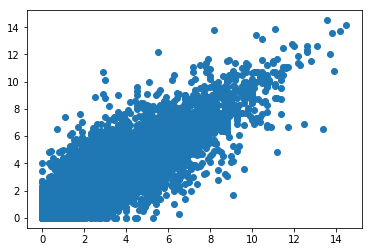

In [30]:
plt.scatter(df['AST'], df['Target']);

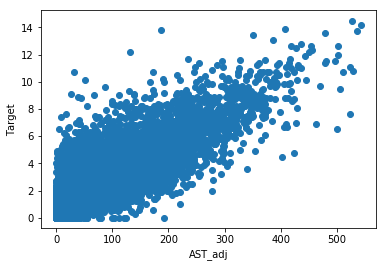

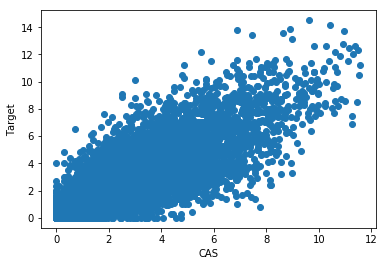

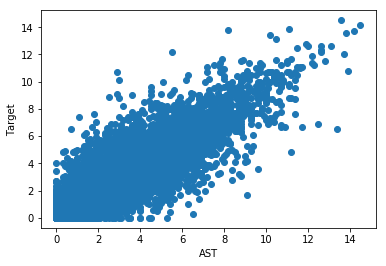

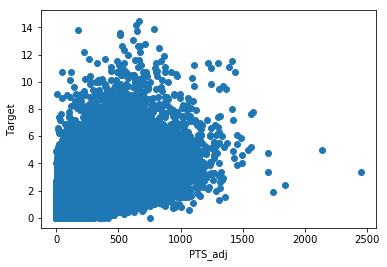

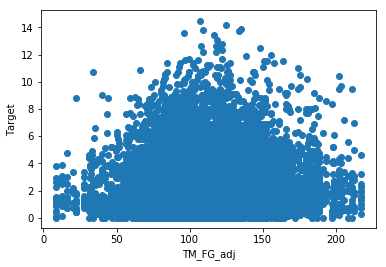

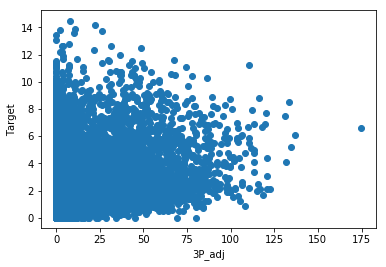

In [31]:
imp_features = ['AST_adj', 'CAS', 'AST', 'PTS_adj', 'TM_FG_adj', '3P_adj']

for feature in imp_features:
    plt.scatter(df[feature], df['Target'])
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

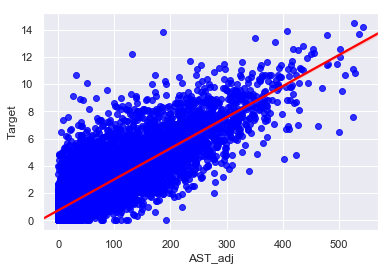

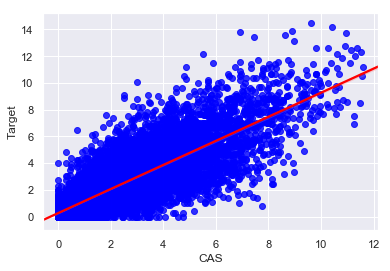

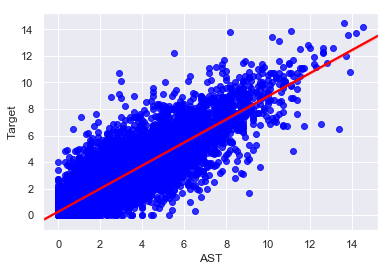

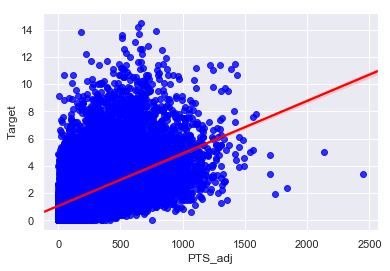

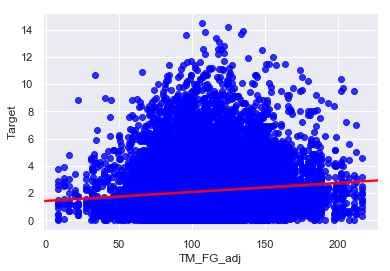

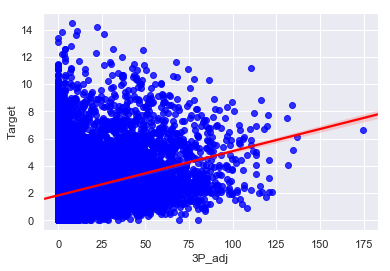

In [32]:
import seaborn as sns

sns.set(color_codes=True)

for feature in imp_features:
    ax = sns.regplot(x=feature, y='Target', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')
    plt.show()

In [53]:
import shap

def explain(row_number):
    row = X_test_encoded.loc[[row_number]]
    
    return shap.force_plot(
        base_value=model.intercept_,
        shap_values=model.coef_,
        features=row,
        feature_names=X_train_encoded.columns
    )
shap.initjs()
explain(6919)

In [54]:
explain(9089)

In [55]:
coefs = pd.DataFrame(model.coef_, index=X_test_encoded.columns)
coefs = coefs.sort_values(0, ascending=False)
imp_coefs = coefs.loc[imp_features]
imp_coefs

ValueError: Cannot index with multidimensional key

In [36]:
permuter.feature_importances_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.38976691e-02,  3.78211885e-02,  2.77483331e-02, -2.06438510e-03,
        2.63727111e-01, -3.53564789e-03, -2.06465033e-03, -2.76562828e-04,
        5.90562499e-05,  3.26495783e-03, -8.62961774e-06, -9.66227674e-04,
        6.31374953e-03, -3.95759931e-04, -9.33265970e-05,  2.23982558e-02,
        4.85523637e-03, -2.85922675e-04,  1.25195692e-03,  1.97350205e-02,
        1.69794157e-03,  4.42082669e-03,  1.16420725e-03,  9.27718432e-03,
        8.39941165e-04,  4.17157735e-02,  7.80484468e-01,  7.86332421e-01,
       -8.46835869e-03,  6.00074723e-02,  1.32948418e-01,  3.56071296e-02,
        3.16785484e-01,  1.97296725e-03,  6.13427716e-07,  1.55065264e-01,
        1.40175182e-01,  1.54485611e-01,  4.59700108e-02,  1.19942522e-01,
        1.99144762e-02,  1.39969802e-03, -1.07178639e-03, -1.26346807e-03,
        3.87982026e-02,  1.66830967e-02, -3.37546664e-04, -2.35204752e-04,
        3.81077855e-03,  

In [37]:
importances = pd.DataFrame(permuter.feature_importances_, index=X_test_encoded.columns)
importances

,0
Year,0.000000
Lge_NBA,0.000000
Lge_ABA,0.000000
Lge_BAA,0.000000
Pos,0.053898
...,...
TM_PF_adj,-0.001421
TM_PTS_adj,0.147044
TM_AST_adj,0.002791
TM_CAS_adj,0.005354


In [38]:
imp_features = importances.loc[importances[0] > 0.02]
imp_features = imp_features.sort_values(by=0, ascending=False)
imp_features

,0
PTS_adj,0.856141
AST_adj,0.803165
CAS,0.786332
AST,0.780484
TM_FG_adj,0.549443
3P_adj,0.316785
MP,0.263727
TM_2P_adj,0.179763
2P_adj,0.155065
2P%_adj,0.154486


In [39]:
coefs = pd.DataFrame(model.coef_, index=X_test_encoded.columns)
imp_coefs = coefs.copy()

for feature in coefs.index:
    if (feature in imp_features.index) == False:
        imp_coefs = imp_coefs.drop(feature)
        
imp_coefs

,0
Pos,-0.131605
Age,-0.040130
G,0.004301
MP,-0.043156
FT,0.051266
PTS,0.018987
AST,0.333471
CAS,0.358452
FG_adj,0.001766
FGA_adj,-0.001618


In [40]:
assert imp_features.shape[0] == imp_coefs.shape[0]

In [41]:
model.intercept_

1.745976489625189

In [42]:
intercept = pd.DataFrame([model.intercept_], index=['Start'])
intercept

,0
Start,1.745976


In [43]:
imp_coefs2 = pd.concat([intercept, imp_coefs])
imp_coefs2.columns = ['Values']
imp_coefs2

,Values
Start,1.745976
Pos,-0.131605
Age,-0.040130
G,0.004301
MP,-0.043156
FT,0.051266
PTS,0.018987
AST,0.333471
CAS,0.358452
FG_adj,0.001766


In [44]:
row_t = X_test_encoded.loc[[6919]].T
row_t

,6919
Year,2018.000000
Lge_NBA,1.000000
Lge_ABA,0.000000
Lge_BAA,0.000000
Pos,3.000000
...,...
TM_PF_adj,44.066364
TM_PTS_adj,323.647273
TM_AST_adj,73.960000
TM_CAS_adj,61.300965


In [45]:
imp_coefs3 = imp_coefs2.reset_index()
row_t = row_t.reset_index()
row_t

,index,6919
0,Year,2018.000000
1,Lge_NBA,1.000000
2,Lge_ABA,0.000000
3,Lge_BAA,0.000000
4,Pos,3.000000
...,...,...
98,TM_PF_adj,44.066364
99,TM_PTS_adj,323.647273
100,TM_AST_adj,73.960000
101,TM_CAS_adj,61.300965


In [46]:
predict_row1 = imp_coefs3.merge(row_t, on='index', how='inner')
predict_row1

,index,Values,6919
0,Pos,-0.131605,3.000000
1,Age,-0.040130,27.000000
2,G,0.004301,1.000000
3,MP,-0.043156,5.000000
4,FT,0.051266,0.000000
5,PTS,0.018987,2.000000
6,AST,0.333471,0.000000
7,CAS,0.358452,2.962500
8,FG_adj,0.001766,5.000000
9,FGA_adj,-0.001618,10.000000


In [47]:
predict_row1['preds'] = predict_row1['Values'] * predict_row1[6919]
predict_row1

,index,Values,6919,preds
0,Pos,-0.131605,3.000000,-0.394816
1,Age,-0.040130,27.000000,-1.083511
2,G,0.004301,1.000000,0.004301
3,MP,-0.043156,5.000000,-0.215779
4,FT,0.051266,0.000000,0.000000
5,PTS,0.018987,2.000000,0.037973
6,AST,0.333471,0.000000,0.000000
7,CAS,0.358452,2.962500,1.061914
8,FG_adj,0.001766,5.000000,0.008829
9,FGA_adj,-0.001618,10.000000,-0.016181


In [48]:
predict_row1['abs_pred'] = abs(predict_row1['preds'])
predict_row1 = predict_row1.sort_values(by='abs_pred', ascending=False)
predict_row1

,index,Values,6919,preds,abs_pred
21,TM_FG_adj,-0.028855,118.160000,-3.409525,3.409525
22,TM_FGA_adj,-0.005782,262.820909,-1.519577,1.519577
24,TM_2P_adj,0.016448,88.309091,1.452495,1.452495
26,TM_PTS_adj,0.004222,323.647273,1.366598,1.366598
23,TM_3P_adj,0.040757,30.011818,1.223189,1.223189
1,Age,-0.040130,27.000000,-1.083511,1.083511
7,CAS,0.358452,2.962500,1.061914,1.061914
25,TM_2PA_adj,0.005207,178.192727,0.927803,0.927803
0,Pos,-0.131605,3.000000,-0.394816,0.394816
14,2P%_adj,0.054674,5.000000,0.273371,0.273371


In [49]:
predict_row1 = pd.concat([intercept, predict_row1])
predict_row1

,0,6919,Values,abs_pred,index,preds
Start,1.745976,NaN,NaN,NaN,NaN,NaN
21,NaN,118.160000,-0.028855,3.409525,TM_FG_adj,-3.409525
22,NaN,262.820909,-0.005782,1.519577,TM_FGA_adj,-1.519577
24,NaN,88.309091,0.016448,1.452495,TM_2P_adj,1.452495
26,NaN,323.647273,0.004222,1.366598,TM_PTS_adj,1.366598
23,NaN,30.011818,0.040757,1.223189,TM_3P_adj,1.223189
1,NaN,27.000000,-0.040130,1.083511,Age,-1.083511
7,NaN,2.962500,0.358452,1.061914,CAS,1.061914
25,NaN,178.192727,0.005207,0.927803,TM_2PA_adj,0.927803
0,NaN,3.000000,-0.131605,0.394816,Pos,-0.394816


In [50]:
predict_row1 = predict_row1.fillna({'index': 'Start'})
predict_row1

,0,6919,Values,abs_pred,index,preds
Start,1.745976,NaN,NaN,NaN,Start,NaN
21,NaN,118.160000,-0.028855,3.409525,TM_FG_adj,-3.409525
22,NaN,262.820909,-0.005782,1.519577,TM_FGA_adj,-1.519577
24,NaN,88.309091,0.016448,1.452495,TM_2P_adj,1.452495
26,NaN,323.647273,0.004222,1.366598,TM_PTS_adj,1.366598
23,NaN,30.011818,0.040757,1.223189,TM_3P_adj,1.223189
1,NaN,27.000000,-0.040130,1.083511,Age,-1.083511
7,NaN,2.962500,0.358452,1.061914,CAS,1.061914
25,NaN,178.192727,0.005207,0.927803,TM_2PA_adj,0.927803
0,NaN,3.000000,-0.131605,0.394816,Pos,-0.394816


In [51]:
predict_row1 = predict_row1.reset_index(drop=True)
results = []
for i in range(len(predict_row1)):
    if i == 0:
        results.append(predict_row1.iloc[0,0])
    else:
        result = results[i-1] + predict_row1.loc[i, 'preds']
        results.append(result)
        
predict_row1['results'] = results
predict_row1

,0,6919,Values,abs_pred,index,preds,results
0,1.745976,NaN,NaN,NaN,Start,NaN,1.745976
1,NaN,118.160000,-0.028855,3.409525,TM_FG_adj,-3.409525,-1.663548
2,NaN,262.820909,-0.005782,1.519577,TM_FGA_adj,-1.519577,-3.183125
3,NaN,88.309091,0.016448,1.452495,TM_2P_adj,1.452495,-1.730630
4,NaN,323.647273,0.004222,1.366598,TM_PTS_adj,1.366598,-0.364032
5,NaN,30.011818,0.040757,1.223189,TM_3P_adj,1.223189,0.859157
6,NaN,27.000000,-0.040130,1.083511,Age,-1.083511,-0.224354
7,NaN,2.962500,0.358452,1.061914,CAS,1.061914,0.837560
8,NaN,178.192727,0.005207,0.927803,TM_2PA_adj,0.927803,1.765363
9,NaN,3.000000,-0.131605,0.394816,Pos,-0.394816,1.370547


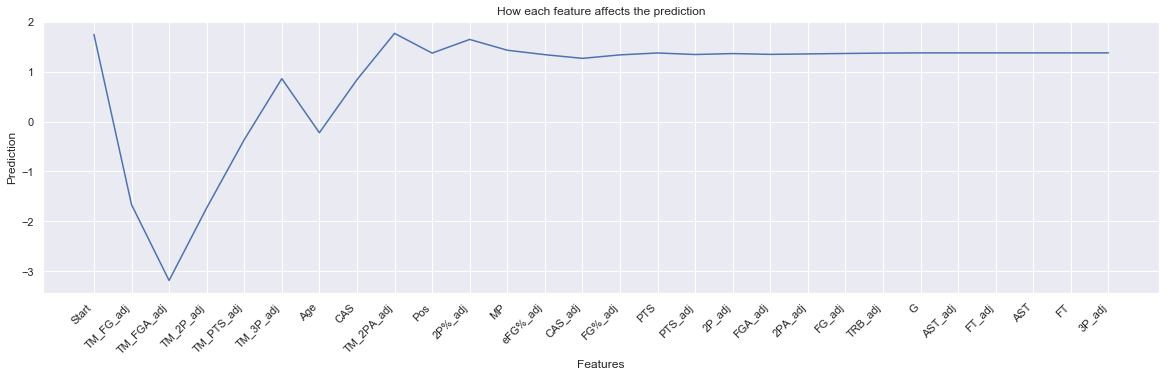

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)

plt.plot(np.arange(0, len(predict_row1)), predict_row1['results'])
ax.set_xticks(np.arange(0, len(predict_row1)))
ax.set_xticklabels(predict_row1['index'], rotation=45, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Prediction')
ax.set_title('How each feature affects the prediction');